# State Farm Distracted Driver Detection
This notebook contains code for State Farm Distracted Driver Detection dataset chanllenge. Kaggle link: https://www.kaggle.com/c/state-farm-distracted-driver-detection

## Importing packages
Install and import necessary libraries

In [62]:
!pip install --upgrade pip
!pip install tqdm matplotlib pandas

DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.
DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.


In [5]:
import os
import shutil
import glob

import tqdm
import pandas as pd
import cv2
import caffe
import lmdb
import numpy as np
from sklearn.model_selection import train_test_split
from caffe.proto import caffe_pb2
from matplotlib import pyplot as plt

%matplotlib inline

## Preprocessing data
For large dataset we usually split the dataset into 3 subsets: training, validation and testing. We already have a individual test set for final evaluation. So we still need to split the original training set into a training and a validation set for parameters tuning.

As you see the datas are already seperated into each class: one directory for images with label c0, another directory for images with label c1, etc. For loading the dataset thus we don't need the .csv file provided, we can go to the directories one by one and load the images, and for each image we record the parent directory name (c0, c1, ...) as the label for that image.

In [35]:
def prepare_data(data_dir, split=0.2):
    """Load raw data and split it into training and validation subset.
    
    Args
    :data_dir: Data root directory.
    
    Returns
    :X_train: A list of training image paths.
    :y_train: A list of training labels.
    :X_val: A list of validation image paths.
    :y_val: A list of validation labels.
    """
    imgs_list = []
    labels = []

    # List all image subdirectories and sort by class name
    img_dirs = sorted(glob.glob(os.path.join(data_dir, '*')), key = lambda k: k.split("/")[-1])
    for img_dir in img_dirs:
        # Read all the images in this class
        # Image subdirectory name as label
        for img_path in glob.glob(os.path.join(img_dir,'*.jpg')):
            imgs_list.append(img_path)
            labels.append(int(img_dir.split("/")[-1].replace('c', '')))
    
    # Split into training and validation subset
    X_train, X_test, y_train, y_test = train_test_split(imgs_list, labels, test_size = 0.2)

    return np.array(X_train), np.array(X_test), y_train, y_test

## Get data
Here we use the function we just defined above to load data. Make sure you placed the dataset in docker container.

In [36]:
path_train_images = 'imgs/train'
path_test_images = 'imgs/test'

X_train, X_test, y_train, y_test = prepare_data(path_train_images)

print('Size of X_train: {}, size of y_train: {}'.format(len(X_train), len(y_train)))
print('Size of X_test: {}, size of y_test: {}'.format(len(X_test), len(y_test)))

Size of X_train: 17939, size of y_train: 17939
Size of X_test: 4485, size of y_test: 4485


## Data sanity check

Classes:
- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger

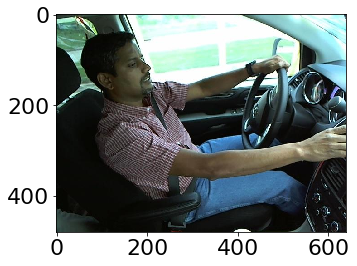

Class: 5


In [38]:
# Load an image
img = cv2.imread(X_train[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

# Check label
print('Class: {}'.format(y_train[0]))

## Data Exploring
It's common in Machine Learning to see how balanced the dataset is. It's the best if our dataset is perfectly balanced. Otherwise we need to apply techniques to address it.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

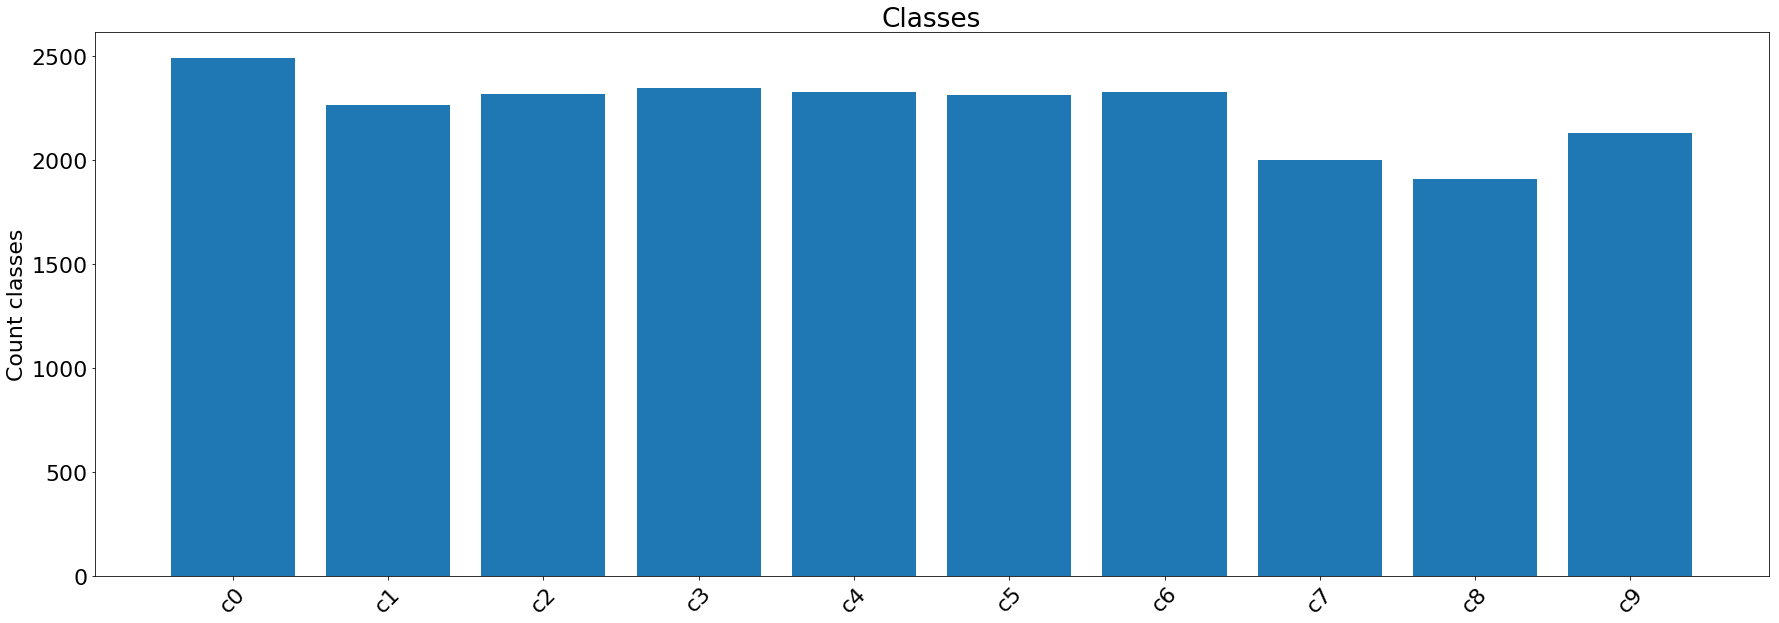

In [39]:
path_label_csv = 'driver_imgs_list.csv'
data_file = pd.read_csv(path_label_csv)
data_x = list(pd.unique(data_file['classname']))

# Clustring all images of each class together
data_classes = data_file.loc[:, ['classname','img']].groupby(by='classname').count().reset_index()
data_y =list(data_classes['img'])

# Plotting them using matplot
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(30,10))
plt.bar(data_x, data_y)
plt.ylabel('Count classes')
plt.title('Classes')
plt.xticks(rotation=45)

Lucky us! The dataset is very nice. All classes are nearly equal in quantity.

## Caffe Overview
Caffe is a deep learning framework developed by the Berkeley Vision and Learning Center (BVLC). It is written in C++ and has Python and Matlab interfaces.

There are 4 steps in training a CNN using Caffe:

- Step 1 - Data preparation: In this step, we get the images and store them in a format that can be used by Caffe. Here we will write a Python script that will handle image storage.

- Step 2 - Model definition: In this step, we choose a CNN architecture and we define its parameters in a configuration file with extension .prototxt.

- Step 3 - Solver definition: The solver is responsible for model optimization. We define the solver parameters in a configuration file with extension .prototxt.

- Step 4 - Model training: We train the model by executing caffe command from the terminal. After training the model, we will get the trained model in a file with extension .caffemodel.

After the training phase, we will use the .caffemodel trained model to make predictions of new unseen data.

## Data preparation
Here we prepare the raw dataset as LMDB database, which is standard Caffe data format. We need some piece of Python code.

In [46]:
import lmdb
import caffe
from caffe.proto import caffe_pb2


def transform_img(img, img_width=224, img_height=224):
    """Resize and normalize image.
    
    Args
    :img: numpy array image.
    :img_width: Target image width.
    :img_height: Target image height.
    
    Returns
      transformed image.
    """
    img = cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_CUBIC)

    # TODO: normalize
    return img


def make_datum(img, label):
    """
    Convert original numpy array image to datum
    Args
    :img: numpy.ndarray (BGR instead of RGB)
    :label: int
    """
    return caffe_pb2.Datum(
        channels=3,
        width=224,
        height=224,
        label=label,
        data=np.rollaxis(img, 2).tostring())


def make_lmdb(lmdb_path, x_data, y_data):
    """Create LMDB database from the given raw images and labels.
    
    Args
    :lmdb_path: LMDB output path.
    :x_data: A list of image paths.
    :y_data: A list of labels.
    """
    in_db = lmdb.open(lmdb_path, map_size=int(1e12))
    with in_db.begin(write=True) as in_txn:
        for in_idx, img_path in tqdm.tqdm(enumerate(x_data)):
            img = cv2.imread(img_path)
            img = transform_img(img)
            datum = make_datum(img, y_data[in_idx])  # Making datum object
            in_txn.put('{:0>5d}'.format(in_idx).encode('utf-8'), datum.SerializeToString())
    in_db.close()

In [48]:
# Actually create training and validation database
train_lmdb = 'input/train_lmdb'
val_lmdb = 'input/validation_lmdb'

os.makedirs(train_lmdb, exist_ok=True)
os.makedirs(val_lmdb, exist_ok=True)
make_lmdb(train_lmdb, X_train, y_train)
make_lmdb(val_lmdb, X_test, y_test)

17939it [01:16, 233.56it/s]
4485it [00:17, 249.94it/s]


## Create architecture
Caffe philosophy is expressivity and speed. For that we use text files to define networks, instead of code API like Keras. Coding is possible in Caffe too, but highly discoureged.

After deciding on the CNN architecture, we need to define its parameters in a .prototxt file. Here is the details of the defined network structure in my git repo.

### 1. Data Layer
Data enters Caffe through data layers: they lie at the bottom of nets. Data can come from efficient databases (LevelDB or LMDB), directly from memory, or, when efficiency is not critical, from files on disk in HDF5 or common image formats. Parameters we have in data layer:

- source: the path to the datas it needs to read
- backend: specifies the data type that we read
- batch_size: specifies the size of image batches to read at each step
- transform_param: input transformation params. In computer vision task, it's common to normalize input images. Here we provide 3 mean values correspond to 3 image channels. `mirror` means horizontal flip augmentation.
```
layer {
  name: “data”
  type: “Data”
  include {
    phase: TRAIN   # Or TEST
  }
  data_param {
    source: "./input/train_lmdb"
    backend: LMDB
    batch_size: 32
  }
  top: “data”
  top: “label”
  transform_param {
    crop_size: 224
    mean_value: 104
    mean_value: 117
    mean_value: 123
    mirror: true
 }
}
```
### 2. Convolution layer
This layer recieves the data blob from last layer and produces conv1 blob. Convolution layers in neural networks generally convolve the input image with a set of learnable filters, each producing one feature map in the output image.

This layer produces 64 filters and kernel size is 3 with the stride of 1 done on input. Fillers help us initialize weight and bias values randomly. Here we use Xavier algorithm to automatically initialize weights based on the number of input and output neurons. And for bias we use a simple constant number of zero. lr_mult is also the settings for learning rate, here we set the learning rate for weights same as the resolver in runtime and the learning rate for bias twice of that.

```
layer {
  name: "conv1"
  type: "Convolution"
  param { lr_mult: 1 }
  param { lr_mult: 2 }
  convolution_param {
    num_output: 64
    kernel_size: 3
    stride: 1
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
  bottom: "data"
  top: "conv1"
}
```
### 3. Pooling layer
We set the pool to max so it does max pooling operation on convolution outputs.

```
layer {
  name: "pool1"
  type: "Pooling"
  pooling_param {
    kernel_size: 2
    stride: 2
    pool: MAX
  }
  bottom: "conv1"
  top: "pool1"
}
```
### 4. Dense layer
This layer is similar to previous layers too. Dense layers are knows as InnerProduct layers in Caffe. Here we have a dense layer which has 128 output and parameters is same as previous layers explained.

```
layer {
  name: "ip1"
  type: "InnerProduct"
  param { lr_mult: 1 }
  param { lr_mult: 2 }
  inner_product_param {
    num_output: 128
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
  bottom: "pool2"
  top: "ip1"
}
```
### 5. ReLU layer
Since ReLU is element-wise we can do the operation once and not waste memory. This can be done with defining one name for top and bottom layers. Note that we can not have same names for blob of other layers and this is pecuilar for this layer.
```
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "ip1"
  top: "ip1"
}
```

After ReLU we define another Dense layer with bottom: "ip1" and top: "ip2"

### 6. Loss
We define loss as follow:
```
layer {
  name: "loss"
  type: "SoftmaxWithLoss"
  bottom: "ip2"
  bottom: "label"
}
```

## Caffe Solver
The solver is responsible for model optimization. We define the solver's parameters in a .prototxt file. 

This solver computes the accuracy of the model using the validation set every 1000 iterations. The optimization process will run for a maximum of 40000 iterations and will take a snapshot of the trained model every 5000 iterations.

base_lr, lr_policy, gamma, momentum and weight_decay are hyperparameters that we need to tune to get a good convergence of the model.

we chose lr_policy: "step" with stepsize: 2500, base_lr: 0.001 and gamma: 0.1. In this configuration, we will start with a learning rate of 0.001, and we will drop the learning rate by a factor of ten every 2500 iterations.

There are different strategies for the optimization process. For a detailed explanation, you can read Caffe's solver documentation.
```
net: "caffe-cnn/cnn/cnn.prototxt"
test_interval: 1000
base_lr: 0.001
lr_policy: "step"
gamma: 0.1
stepsize: 2500
display: 50
max_iter: 40000
momentum: 0.9
weight_decay: 0.0005
snapshot: 5000
snapshot_prefix: "./snapshot/cnn"
solver_mode: CPU

```

## Training
We defined the network archirecture and solver in git repo. So just clone it and run the solver.

In [49]:
!git clone https://github.com/tamnguyenvan/caffe-cnn

Cloning into 'caffe-cnn'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 76 (delta 33), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (76/76), done.
Checking connectivity... done.


In [60]:
!mkdir -p ./snapshot/cnn
!caffe train --solver "caffe-cnn/cnn/cnn_solver.prototxt"

I0123 09:15:48.959340   220 upgrade_proto.cpp:1113] snapshot_prefix was a directory and is replaced to ./snapshot/cnn/cnn_solver
I0123 09:15:48.961799   220 caffe.cpp:197] Use CPU.
I0123 09:15:48.961906   220 solver.cpp:45] Initializing solver from parameters: 
test_iter: 141
test_interval: 50
base_lr: 0.001
display: 50
max_iter: 40000
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 2500
snapshot: 5000
snapshot_prefix: "./snapshot/cnn/cnn_solver"
solver_mode: CPU
net: "caffe-cnn/cnn/cnn.prototxt"
train_state {
  level: 0
  stage: ""
}
I0123 09:15:48.962036   220 solver.cpp:102] Creating training net from net file: caffe-cnn/cnn/cnn.prototxt
I0123 09:15:48.962431   220 net.cpp:294] The NetState phase (0) differed from the phase (1) specified by a rule in layer data
I0123 09:15:48.962457   220 net.cpp:294] The NetState phase (0) differed from the phase (1) specified by a rule in layer accuracy
I0123 09:15:48.962607   220 net.cpp:51] Initializing net from paramet

I0123 09:15:49.024788   220 net.cpp:122] Setting up fc5
I0123 09:15:49.024832   220 net.cpp:129] Top shape: 32 512 (16384)
I0123 09:15:49.024852   220 net.cpp:137] Memory required for data: 187121792
I0123 09:15:49.024876   220 layer_factory.hpp:77] Creating layer relu5
I0123 09:15:49.024902   220 net.cpp:84] Creating Layer relu5
I0123 09:15:49.024919   220 net.cpp:406] relu5 <- fc5
I0123 09:15:49.024937   220 net.cpp:367] relu5 -> fc5 (in-place)
I0123 09:15:49.024958   220 net.cpp:122] Setting up relu5
I0123 09:15:49.024974   220 net.cpp:129] Top shape: 32 512 (16384)
I0123 09:15:49.024987   220 net.cpp:137] Memory required for data: 187187328
I0123 09:15:49.025002   220 layer_factory.hpp:77] Creating layer drop5
I0123 09:15:49.025027   220 net.cpp:84] Creating Layer drop5
I0123 09:15:49.025041   220 net.cpp:406] drop5 <- fc5
I0123 09:15:49.025056   220 net.cpp:367] drop5 -> fc5 (in-place)
I0123 09:15:49.025082   220 net.cpp:122] Setting up drop5
I0123 09:15:49.025097   220 net.cpp:12

I0123 09:15:49.093998   220 net.cpp:122] Setting up fc5
I0123 09:15:49.094326   220 net.cpp:129] Top shape: 32 512 (16384)
I0123 09:15:49.094434   220 net.cpp:137] Memory required for data: 187122048
I0123 09:15:49.094466   220 layer_factory.hpp:77] Creating layer relu5
I0123 09:15:49.094491   220 net.cpp:84] Creating Layer relu5
I0123 09:15:49.094506   220 net.cpp:406] relu5 <- fc5
I0123 09:15:49.094532   220 net.cpp:367] relu5 -> fc5 (in-place)
I0123 09:15:49.094552   220 net.cpp:122] Setting up relu5
I0123 09:15:49.094568   220 net.cpp:129] Top shape: 32 512 (16384)
I0123 09:15:49.094648   220 net.cpp:137] Memory required for data: 187187584
I0123 09:15:49.094669   220 layer_factory.hpp:77] Creating layer drop5
I0123 09:15:49.094688   220 net.cpp:84] Creating Layer drop5
I0123 09:15:49.094702   220 net.cpp:406] drop5 <- fc5
I0123 09:15:49.094719   220 net.cpp:367] drop5 -> fc5 (in-place)
I0123 09:15:49.094739   220 net.cpp:122] Setting up drop5
I0123 09:15:49.094755   220 net.cpp:12

During the training process, we need to monitor the loss and the model accuracy. We can stop the process at anytime by pressing stop button. Caffe will take a snapshot of the trained model every 5000 iterations, and store them under `./snapshot/cnn` folder.

The snapshots have .caffemodel extension. For example, 5000 iterations snapshot will be called: `cnn_iter_5000.caffemodel`

## Prediction
We will use the trained model to make prediction on test data.

In [ ]:
import caffe

net = caffe.Net('caffe-cnn/cnn/cnn.prototxt',
                './snapshot/cnn/cnn_iter_1000.caffemodel', caffe.TEST)

In [ ]:
out = net.forward()
pred_probas = out['prob']
print(pred_probas.argmax())

## Transfer Learning
Caffe comes with a repository that is used by researchers and machine learning practitioners to share their trained models. This library is called Model Zoo.

Using this command we download the CaffeNet network structure, trained on ImageNet dataset.

In [ ]:
!gdown https://drive.google.com/uc?id=1s1pBVYak923NPB7EP1TAaVQn-hj-S2Vx

In [ ]:
!caffe train --solver="caffe-cnn/vgg/vgg16_solver.prototxt" --weights "VGG_ILSVRC_16_layers.caffemodel"

I0123 09:37:14.271703   297 caffe.cpp:197] Use CPU.
I0123 09:37:14.272220   297 solver.cpp:45] Initializing solver from parameters: 
test_iter: 141
test_interval: 1000
base_lr: 0.0005
display: 10
max_iter: 20000
lr_policy: "step"
gamma: 0.001
momentum: 0.9
weight_decay: 0.0005
stepsize: 1000
snapshot: 5000
snapshot_prefix: "./snapshot/vgg"
solver_mode: CPU
net: "caffe-cnn/vgg/vgg16.prototxt"
train_state {
  level: 0
  stage: ""
}
weights: "VGG_ILSVRC_16_layers.caffemodel"
I0123 09:37:14.272357   297 solver.cpp:102] Creating training net from net file: caffe-cnn/vgg/vgg16.prototxt
I0123 09:37:14.272855   297 net.cpp:294] The NetState phase (0) differed from the phase (1) specified by a rule in layer data
I0123 09:37:14.272889   297 net.cpp:294] The NetState phase (0) differed from the phase (1) specified by a rule in layer accuracy/top1
I0123 09:37:14.272917   297 net.cpp:294] The NetState phase (0) differed from the phase (1) specified by a rule in layer accuracy/top5
I0123 09:37:14.27

I0123 09:37:14.309253   297 net.cpp:122] Setting up conv4_2
I0123 09:37:14.309330   297 net.cpp:129] Top shape: 32 512 28 28 (12845056)
I0123 09:37:14.309350   297 net.cpp:137] Memory required for data: 3436052608
I0123 09:37:14.309381   297 layer_factory.hpp:77] Creating layer relu4_2
I0123 09:37:14.309410   297 net.cpp:84] Creating Layer relu4_2
I0123 09:37:14.309428   297 net.cpp:406] relu4_2 <- conv4_2
I0123 09:37:14.309449   297 net.cpp:367] relu4_2 -> conv4_2 (in-place)
I0123 09:37:14.309474   297 net.cpp:122] Setting up relu4_2
I0123 09:37:14.309494   297 net.cpp:129] Top shape: 32 512 28 28 (12845056)
I0123 09:37:14.309509   297 net.cpp:137] Memory required for data: 3487432832
I0123 09:37:14.309525   297 layer_factory.hpp:77] Creating layer conv4_3
I0123 09:37:14.309549   297 net.cpp:84] Creating Layer conv4_3
I0123 09:37:14.309566   297 net.cpp:406] conv4_3 <- conv4_2
I0123 09:37:14.309585   297 net.cpp:380] conv4_3 -> conv4_3
I0123 09:37:14.315284   297 net.cpp:122] Setting 

[libprotobuf WARNING google/protobuf/io/coded_stream.cc:537] Reading dangerously large protocol message.  If the message turns out to be larger than 2147483647 bytes, parsing will be halted for security reasons.  To increase the limit (or to disable these warnings), see CodedInputStream::SetTotalBytesLimit() in google/protobuf/io/coded_stream.h.
[libprotobuf WARNING google/protobuf/io/coded_stream.cc:78] The total number of bytes read was 553432081
I0123 09:37:15.038494   297 upgrade_proto.cpp:55] Attempting to upgrade input file specified using deprecated V1LayerParameter: VGG_ILSVRC_16_layers.caffemodel
I0123 09:37:15.647022   297 upgrade_proto.cpp:63] Successfully upgraded file specified using deprecated V1LayerParameter
I0123 09:37:15.671818   297 upgrade_proto.cpp:69] Attempting to upgrade input file specified using deprecated input fields: VGG_ILSVRC_16_layers.caffemodel
I0123 09:37:15.671847   297 upgrade_proto.cpp:72] Successfully upgraded file specified using deprecated input 

I0123 09:37:15.830464   297 net.cpp:122] Setting up conv2_1
I0123 09:37:15.830474   297 net.cpp:129] Top shape: 32 128 112 112 (51380224)
I0123 09:37:15.830479   297 net.cpp:137] Memory required for data: 1971716608
I0123 09:37:15.830489   297 layer_factory.hpp:77] Creating layer relu2_1
I0123 09:37:15.830497   297 net.cpp:84] Creating Layer relu2_1
I0123 09:37:15.830503   297 net.cpp:406] relu2_1 <- conv2_1
I0123 09:37:15.830509   297 net.cpp:367] relu2_1 -> conv2_1 (in-place)
I0123 09:37:15.830518   297 net.cpp:122] Setting up relu2_1
I0123 09:37:15.830523   297 net.cpp:129] Top shape: 32 128 112 112 (51380224)
I0123 09:37:15.830528   297 net.cpp:137] Memory required for data: 2177237504
I0123 09:37:15.830533   297 layer_factory.hpp:77] Creating layer conv2_2
I0123 09:37:15.830541   297 net.cpp:84] Creating Layer conv2_2
I0123 09:37:15.830546   297 net.cpp:406] conv2_2 <- conv2_1
I0123 09:37:15.830554   297 net.cpp:380] conv2_2 -> conv2_2
I0123 09:37:15.830827   297 net.cpp:122] Sett

I0123 09:37:16.002509   297 net.cpp:122] Setting up fc6
I0123 09:37:16.002542   297 net.cpp:129] Top shape: 32 4096 (131072)
I0123 09:37:16.002549   297 net.cpp:137] Memory required for data: 3683844608
I0123 09:37:16.002562   297 layer_factory.hpp:77] Creating layer relu6
I0123 09:37:16.002574   297 net.cpp:84] Creating Layer relu6
I0123 09:37:16.002583   297 net.cpp:406] relu6 <- fc6
I0123 09:37:16.002593   297 net.cpp:367] relu6 -> fc6 (in-place)
I0123 09:37:16.002602   297 net.cpp:122] Setting up relu6
I0123 09:37:16.002609   297 net.cpp:129] Top shape: 32 4096 (131072)
I0123 09:37:16.002615   297 net.cpp:137] Memory required for data: 3684368896
I0123 09:37:16.002621   297 layer_factory.hpp:77] Creating layer drop6
I0123 09:37:16.002630   297 net.cpp:84] Creating Layer drop6
I0123 09:37:16.002635   297 net.cpp:406] drop6 <- fc6
I0123 09:37:16.002642   297 net.cpp:367] drop6 -> fc6 (in-place)
I0123 09:37:16.002651   297 net.cpp:122] Setting up drop6
I0123 09:37:16.002658   297 net.

[libprotobuf WARNING google/protobuf/io/coded_stream.cc:537] Reading dangerously large protocol message.  If the message turns out to be larger than 2147483647 bytes, parsing will be halted for security reasons.  To increase the limit (or to disable these warnings), see CodedInputStream::SetTotalBytesLimit() in google/protobuf/io/coded_stream.h.
[libprotobuf WARNING google/protobuf/io/coded_stream.cc:78] The total number of bytes read was 553432081
I0123 09:37:16.414149   297 upgrade_proto.cpp:55] Attempting to upgrade input file specified using deprecated V1LayerParameter: VGG_ILSVRC_16_layers.caffemodel
I0123 09:37:17.046797   297 upgrade_proto.cpp:63] Successfully upgraded file specified using deprecated V1LayerParameter
I0123 09:37:17.075114   297 upgrade_proto.cpp:69] Attempting to upgrade input file specified using deprecated input fields: VGG_ILSVRC_16_layers.caffemodel
I0123 09:37:17.075147   297 upgrade_proto.cpp:72] Successfully upgraded file specified using deprecated input 

Test this transfer learning model